In [1]:
!nvidia-smi

Tue Jun 17 14:09:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              3W /   10W |     478MiB /   6141MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
%matplotlib inline
import albumentations as A
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
import torch
from ultralytics import YOLO
import shutil
import cv2
import numpy as np
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image
from __future__ import print_function

In [6]:
#check whether cuda is enabled
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
# set device to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
0
1
NVIDIA GeForce RTX 4050 Laptop GPU
cuda


In [7]:
# define 4 classes
classes = ['left_AP', 'right_AP', 'left_outlet', 'right_outlet']
train_data_src_path = 'original_data/train'

In [8]:
# helper functions

# create augmentation pipeline
def crop_image(img, crop_percent):
    return img[int(crop_percent*img.shape[0]):int((1-crop_percent)*img.shape[0]), int(crop_percent*img.shape[1]):int((1-crop_percent)*img.shape[1])]

def create_val_folder(folder_path, src_path='original_data/val'):
    '''
        creates val folder with frames from specidied video num from src path to vide path
        
        Args:
            folder_path: path to folder to create val folder
            src_path: path to folder with train data

        Returns: 
            None
    '''
    shutil.rmtree(folder_path, ignore_errors=True)
    for class_name in classes:
        curr_folder = os.path.join(src_path, class_name)
        output_folder = os.path.join(folder_path, class_name)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # list all images in folder
        image_files = [f for f in os.listdir(curr_folder) if f.endswith('.jpg')]

        for img_name in image_files:
            img_path = os.path.join(curr_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue
            cv2.imwrite(os.path.join(output_folder, img_name), img)  
    
    print('Created val folder at ' + folder_path)  

def perform_augment(augmentation, classes, folder_path, src_path, val_video_num, iteration, bounding_box, crop):
      for class_name in classes:
        curr_folder = os.path.join(src_path, class_name)
        output_folder = folder_path + '/' + class_name
        if iteration == 0:
            shutil.rmtree(output_folder, ignore_errors=True)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # list all images in folder
        image_files = []
      
        for f in os.listdir(curr_folder):
            tokens = f.split(' ')
            if not tokens[1].startswith(str(val_video_num)):
                image_files.append(f)

        for img_name in image_files:
            img_path = os.path.join(curr_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue
            
            # get image dimensions
            h, w = img.shape[:2]

            # calc middle coordinate
            middle_x = w // 2
            # draw line down middle
            cv2.line(img, (middle_x, 0), (middle_x, h), (0, 255, 0), 2)
            
            if crop and not bounding_box and iteration == 0: # only for first iteration
                # dynamically crop 20% of image based on size
                image = img[int(0.1*h):int(0.91*h), int(0.1*w):int(0.91*w)]

            # perform augmentation
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented_image = augmentation(image=image)['image']

            # Convert back to BGR to save in OpenCV
            final_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
            img_name = img_name.split('.')[0] + '_' + str(iteration) + '.jpg'
            save_path = os.path.join(output_folder, img_name)
            cv2.imwrite(save_path, final_image)

def augment_images(degrees, classes, folder_path, src_path, iterations, bounding_box=False, crop=False):
    '''
        creates augmentation pipeline and performs augmentation on images for specified number of iterations

        Parameters:
            degrees: degrees to rotate images
            classes: list of classes to augment
            folder_path: path to folder to create val folder
            src_path: path to folder with train data
            iterations: number of augmentation iterations
            bounding_box: if False, crops using standard 10% crop around edges, else don't crop
        
        Returns: 
            None
    '''
    augmentation = A.Compose([
        A.Rotate(limit=(-1 * degrees, degrees)),
    ])

    for i in range(iterations):
        print('Performing augmentation iteration ' + str(i) + '...')
        perform_augment(augmentation, classes, folder_path, src_path, 14, i, bounding_box, crop)
    
    print('Saved augmented images to ' + folder_path)

def display_hd_matplotlib(image_path):
    '''
        displays image using matplotlib
        
        Args:
            image_path: path to image to display
        
        Returns: 
            None
    '''
    # Create figure with high DPI
    plt.figure(figsize=(10, 8), dpi=150)
    
    # Read and display image
    img = mpimg.imread(image_path)
    plt.imshow(img, interpolation='lanczos')  # Better interpolation method
    plt.axis('off')
    
    # Remove whitespace around the image
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    plt.show()

def get_binary_img(img, threshold_type): 
    '''
        thresholds image and returns binary image
        
        Args:
            img(cv2 image): image to threshold
            threshold_type: threshold type
        
        Returns: 
            img: binary image
    '''
    print('creating binary image...')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img, 195, 255, threshold_type)
    return thresh

def draw_contours(img, bin_img):
    '''
        draws contours on image
        
        Args:
            img(cv2 image): image to draw contours on
            bin_img(cv2 image): binary image to draw contours from
        
        Returns: 
            image with contours drawn
    '''
    print('drawing contours...')
    contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # draw contours on image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
    return img

# crop bounding box
def crop_bounding_box(results, image):
    '''
        crops image based on bounding box returned by YOLOv11 model
        
        Args:
            results: YOLOv11 model output
            image: image to crop
            
        Returns:
            cropped: cropped image
    '''
    print('cropping bounding box...')
    boxes = results.boxes.xyxy.cpu().numpy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cropped = image[y1:y2, x1:x2]
        return cropped

In [27]:
# copy images from untouched folder to original_data folder
shutil.rmtree('original_data', ignore_errors=True)
shutil.copytree('untouched_original_data', 'original_data')

'original_data'

In [28]:
# extract images for validation dataset (video 14)

# delete existing folder
print('extracting images for validation dataset (video 14)')

if os.path.exists('original_data/val'):
    shutil.rmtree('original_data/val')

for class_name in classes:
    curr_folder = os.path.join('original_data/train', class_name)
    output_folder = 'original_data/val/' + class_name
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for file in os.listdir(curr_folder):
        tokens = file.split(' ')
        if tokens[1].startswith('14') and file.endswith(('.jpg', 'jpeg', 'png')):
            shutil.copy(os.path.join(curr_folder, file), output_folder)
            os.remove(os.path.join(curr_folder, file))
print('done')

extracting images for validation dataset (video 14)
done


In [9]:
def process_images(classes, dest_path, src_path, crop=False, line=False, crop_percent=0.1, bounding_box=False, det_model=None, contours=False, grayscale=False):
    '''
        processes images with specified augmentations

        Parameters:
            classes: list of classes to augment
            dest_path: path to folder to create val folder
            crop: if True, crops image
            line: if True, draws line down middle of image
            crop_percent: crop percent
            bounding_box: if True, crops image to bounding box
            det_model: object detection model
            src_path: path to folder with train data
            contours: if True, draws contours on image
        
        Returns: 
            None
    '''
    print(f'Performing preprocessing on data from ' + src_path)

    shutil.rmtree(dest_path, ignore_errors=True)
        
    for class_name in classes:
        print('Processing ' + class_name)
        target_folder = os.path.join(src_path, class_name)
        output_folder = os.path.join(dest_path, class_name)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        else:
            shutil.rmtree(output_folder)
        
        for file in os.listdir(target_folder):
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(target_folder, file))

                if grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                if contours:
                    bin_img = get_binary_img(img, cv2.THRESH_BINARY)
                    processed_img  = draw_contours(img, bin_img)

                if crop:
                    # crop image
                    processed_img = crop_image(img, crop_percent)
                
                    if line:
                        h, w = processed_img.shape[:2]

                        # calc middle coordinate
                        middle_x = w // 2

                        # draw line down middle
                        cv2.line(processed_img, (middle_x, 0), (middle_x, h), (0, 255, 0), 2)
                

                if bounding_box:
                    results = det_model(os.path.join(target_folder, file))
                    for result in results:
                        if hasattr(result, 'boxes') and hasattr(result, 'names'):
                            for box in result.boxes:
                                class_id = int(box.cls)
                                class_name_detected = result.names[class_id]

                                if class_name_detected == 'person':

                                    processed_img = crop_bounding_box(result, img)
                
                                    if line:
                                        h, w = processed_img.shape[:2]

                                        # calc middle coordinate
                                        middle_x = w // 2

                                        # draw line down middle
                                        cv2.line(processed_img, (middle_x, 0), (middle_x, h), (0, 255, 0), 2)

                                    # save image
                                    cv2.imwrite(os.path.join(output_folder, file), processed_img)
                else:
                    # save image
                    cv2.imwrite(os.path.join(output_folder, file), processed_img)
                
    print('Saved processed images to ' + dest_path)

### Preparing grayscale train images ###

In [11]:
# convert images to grayscale, and save into grayscale_train folder
process_images(classes, src_path=train_data_src_path, dest_path='grayscale_train/train2', grayscale=True, crop=True, line=True)

Performing preprocessing on data from original_data/train
Processing left_AP
Processing right_AP
Processing left_outlet
Processing right_outlet
Saved processed images to grayscale_train/train2


In [10]:
create_val_folder(folder_path='grayscale_train/val2', src_path='original_data/val')
process_images(classes, src_path='grayscale_train/val2', dest_path='grayscale_train/val', grayscale=True, crop=True, line=True)
shutil.rmtree('grayscale_train/val2', ignore_errors=True)

Created val folder at grayscale_train/val2
Performing preprocessing on data from grayscale_train/val2
Processing left_AP
Processing right_AP
Processing left_outlet
Processing right_outlet
Saved processed images to grayscale_train/val


In [12]:
# augment grayscale images
augment_images(degrees=35, classes=classes, folder_path='grayscale_train/train', src_path='grayscale_train/train2', iterations=4)
shutil.rmtree('grayscale_train/train2', ignore_errors=True)

Performing augmentation iteration 0...
Performing augmentation iteration 1...
Performing augmentation iteration 2...
Performing augmentation iteration 3...
Saved augmented images to grayscale_train/train


### Preparing bounding box train images ###

In [43]:
# extract bounding boxes from training
det_model = YOLO('yolo11n.pt')
process_images(classes, src_path=train_data_src_path, dest_path='boxed_segments/train', bounding_box=True, det_model=det_model)
create_val_folder(folder_path='boxed_segments')

Performing preprocessing on data from original_data/train
Processing left_AP

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\original_data\train\left_AP\Left 10_ext_10.jpg: 640x640 1 person, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\original_data\train\left_AP\Left 10_ext_12.jpg: 640x640 1 person, 16.5ms
Speed: 3.8ms preprocess, 16.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\original_data\train\left_AP\Left 10_ext_14.jpg: 640x640 1 person, 16.3ms
Speed: 3.7ms preprocess, 16.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\original_data\train\left_AP\Left 10_ext_16.jpg: 640x640 1 person, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users

### Creating augmented training images (rotated, cropped and line) ###

In [14]:
# create data set with rotation augmentation, crop around edges, and save to aug_line folder
augment_images(degrees=35, classes=classes, folder_path='aug_line/train', src_path=train_data_src_path, iterations=5)
create_val_folder('aug_line/val2')
# augment val folder
process_images(classes=classes, dest_path='aug_line/val', src_path='aug_line/val2', crop=True, line=True)
shutil.rmtree('aug_line/val2')

Performing augmentation iteration 0...
Performing augmentation iteration 1...
Performing augmentation iteration 2...
Performing augmentation iteration 3...
Performing augmentation iteration 4...
Saved augmented images to aug_line/train
Created val folder at aug_line/val2
Performing preprocessing on data from aug_line/val2
Processing left_AP
Processing right_AP
Processing left_outlet
Processing right_outlet
Saved processed images to aug_line/val


### Creating images augmented with contours ###

In [45]:
process_images(classes=classes, src_path=train_data_src_path, dest_path='contours/train', contours=True)
create_val_folder('contours')

Performing preprocessing on data from original_data/train
Processing left_AP
Processing right_AP
Processing left_outlet
Processing right_outlet
Saved processed images to contours/train
Created val folder at contours


### Model Training ###

In [ ]:
def train_model(yolo_model, train_data, epochs, optimizer, batch_size, lr0, lrf, dropout):
    # define classification model
    model = YOLO(yolo_model)

    #train the model
    results = model.train(data=train_data, epochs=epochs, device=[0], optimizer=optimizer, batch=batch_size, lr0=lr0, lrf=lrf, workers=8, dropout=dropout)

    return results

# clear cuda cache
torch.cuda.empty_cache()

# train the model
train_model('yolo11l-cls.pt', train_data='grayscale_train', epochs=20, optimizer='AdamW', batch_size=16, lr0=0.001, lrf=0.0001, dropout=0)

New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=grayscale_train, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train45, nbs=64, nms=False, opset=None, 

train: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\grayscale_train\train... 4844 images, 0 corrupt: 100%|██████████| 4844/4844 [00:00<00:00, 5999.74it/s]

train: New cache created: C:\Users\xavie\Desktop\x_ray_classifier_copy\grayscale_train\train.cache


val: Fast image access  (ping: 0.10.0 ms, read: 105.116.3 MB/s, size: 66.2 KB)


val: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\grayscale_train\val... 180 images, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 2792.10it/s]

val: New cache created: C:\Users\xavie\Desktop\x_ray_classifier_copy\grayscale_train\val.cache


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to c:\Users\xavie\Desktop\x_ray_classifier_copy\runs\classify\train45
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20      1.35G      1.287         16        224:   3%|▎         | 9/303 [00:12<06:42,  1.37s/it]


KeyboardInterrupt: 

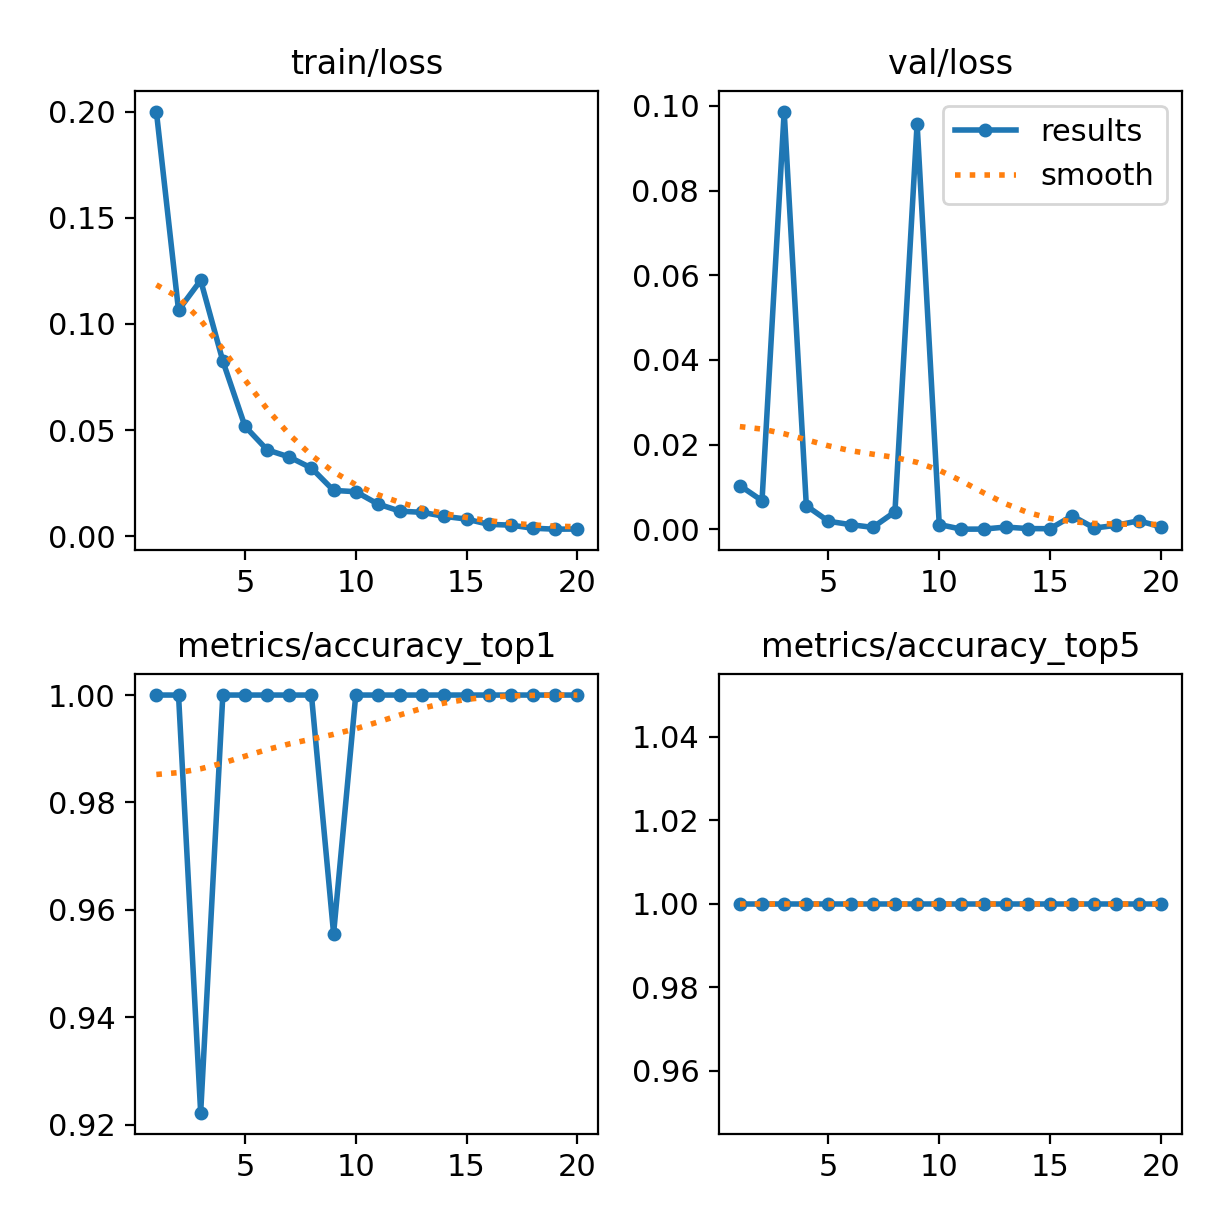

In [15]:
# show training metrics
display_hd_matplotlib('runs/classify/train105/results.png')

### EigenCam Analysis ###

In [11]:
# use eigencam to visualize focus points of image
def process_eigencam(run, image_dir):
    '''
        Processes the images in the test folder and saves the results in the eigencam folder

        Args:
            run(int): run number
        Returns: 
            None
    '''
    if run == 0:
        train_run = 'train'
    else: 
        train_run = 'train' + str(run)

    model = YOLO(f'runs/classify/{train_run}/weights/best.pt')
    target_layers =[model.model.model[-2]]
    cam = EigenCAM(model, target_layers,task='cls')

    for class_name in classes:
        test_folder = f'{image_dir}/{class_name}'
        img_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg', 'png', 'jpeg'))]
        print(f'Processing {len(img_files)} images in class {class_name}')

        for img_file in img_files:
            rgb_img = cv2.imread(os.path.join(test_folder, img_file))
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

            img = rgb_img.copy()
            img = np.float32(img) / 255.0

            grayscale_cam = cam(rgb_img[0, :, :])
            cam_image = (show_cam_on_image(img, grayscale_cam, use_rgb=True))


            # Save results in folder
            save_folder = f'eigencam/{train_run}/{class_name}'
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            cv2.imwrite(f'eigencam/{train_run}/{class_name}/{img_file}', cam_image)
    print('All eigencam images saved to dest path:', f'eigencam/{train_run}')

process_eigencam(105, image_dir='test_seg/test')

Processing 45 images in class left_AP

0: 224x224 right_AP 0.37, left_AP 0.25, right_outlet 0.19, left_outlet 0.19, 49.2ms
Speed: 84.0ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 right_AP 0.40, left_AP 0.29, right_outlet 0.20, left_outlet 0.12, 50.7ms
Speed: 37.7ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 right_AP 0.39, left_AP 0.27, left_outlet 0.17, right_outlet 0.17, 45.1ms
Speed: 43.3ms preprocess, 45.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 right_AP 0.38, left_AP 0.25, right_outlet 0.19, left_outlet 0.18, 82.6ms
Speed: 49.8ms preprocess, 82.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 right_AP 0.37, left_AP 0.25, left_outlet 0.19, right_outlet 0.19, 246.2ms
Speed: 36.3ms preprocess, 246.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 right_AP 0.38, left_AP 0.27, left

### Preparing Test Data ###

In [45]:
def create_test_data(classes, dest_path, src_path, crop=False, bounding_box=False):
    print('Creating test data in ' + dest_path + '...')
    shutil.rmtree(dest_path, ignore_errors=True)
    
    front_view_classes = ['left_outlet', 'right_outlet']
    for class_name in front_view_classes:
        print('Processing front view outlet ' + class_name)
        curr_path = os.path.join(src_path, 'front_view_outlet', class_name)
        imgs = os.listdir(curr_path)
        output_folder = os.path.join(dest_path, class_name)

        for img in imgs:
            img_path = os.path.join(curr_path, img)
            os.makedirs(output_folder, exist_ok=True)
            shutil.copy(img_path, output_folder)
        
    # shift remaining images
    for class_name in classes:
        print('Processing: ' + class_name)
        imgs = os.listdir(os.path.join(src_path, class_name))
        output_folder = os.path.join(dest_path, class_name)

        for img in imgs:
            img_path = os.path.join(src_path, class_name, img)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            shutil.copy(img_path, output_folder)
    
    
    print('Completed preparing test data in folder path ' + dest_path)

create_test_data(classes, 'test/test', 'original_data/test')

Creating test data in test/test...
Processing front view outlet left_outlet
Processing front view outlet right_outlet
Processing: left_AP
Processing: right_AP
Processing: left_outlet
Processing: right_outlet
Completed preparing test data in folder path test/test


In [ ]:
# create test data with 10% crop and line
process_images(classes, dest_path='test_crop_line', crop=True, line=True)

In [ ]:
# create test data with bounding box
det_model = YOLO('yolo11n.pt')
process_images(classes, dest_path='test_bounding_box', bounding_box=True, det_model=det_model, line=True)

Performing augmentation on test data from test/test
Augmenting left_AP

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\test\test\left_AP\Left 15_ext_10.jpg: 608x640 1 person, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 2.4ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\test\test\left_AP\Left 15_ext_12.jpg: 576x640 1 person, 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\test\test\left_AP\Left 15_ext_14.jpg: 608x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\test\test\left_AP\Left 15_ext_16.jpg: 576x640 1 person, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 c:\Users\xavie\Desktop\x_ray_classifier_copy\test\test

In [ ]:
# create test data w contours
process_images(classes, dest_path='test_contours', contours=True)

Performing augmentation on test data from test/test
Augmenting left_AP
Augmenting right_AP
Augmenting left_outlet
Augmenting right_outlet
Saved augmented images to test_contours


In [47]:
# create test data w grayscale images
process_images(classes=classes, dest_path='test_grayscale/test', grayscale=True, crop=True, line=True, crop_percent=0.1, src_path='test/test')

Performing preprocessing on data from test/test
Processing left_AP
Processing right_AP
Processing left_outlet
Processing right_outlet
Saved processed images to test_grayscale/test


### Analysis of runs ###

In [2]:
def evaluate_run(run, test_data_path):
    '''
        evaluates a YOLO classification model on the test data

        Arguments:
            run(int): the run number to evaluate

        Returns:
            test_results: the results of the evaluation
    '''
    if run == 0:
        train_run = 'train'
    else:
        train_run  = f'train{run}'
    # load model to evaluate
    model = YOLO(f'runs/classify/{train_run}/weights/best.pt')
    # evaluate on test data
    test_results = model.val(data=test_data_path, verbose=False)
    # print results
    print("Top 1 Accuracy:", test_results.results_dict['metrics/accuracy_top1'])
    print("Fitness: ", test_results.fitness)
    print("Loss:", test_results.speed['loss'])
    print('------------------------------')
    
    return test_results

In [12]:
# test for crop using segmentation (x4 training data)
evaluate_run(106, 'test_seg/test')

Ultralytics 8.3.145  Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
YOLO11l-cls summary (fused): 94 layers, 12,823,556 parameters, 0 gradients, 49.3 GFLOPs
WARNING Dataset 'split=train' not found at C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test\train
Found 342 images in subdirectories. Attempting to split...
Splitting C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test (4 classes, 342 images) into 80% train, 20% val...
Split complete in C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split 
train: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\train... found 342 images in 4 classes  
val: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val... found 313 images in 4 classes  
test: None...
val: Fast image access  (ping: 0.70.6 ms, read: 514.4580.7 MB/s, size: 345.6 KB)


val: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val... 313 images, 0 corrupt: 100%|██████████| 313/313 [00:00<00:00, 2085.98it/s]

val: New cache created: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val.cache



               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


                   all      0.751          1
Speed: 0.7ms preprocess, 41.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\xavie\Desktop\x_ray_classifier_copy\runs\classify\val103
Top 1 Accuracy: 0.7507987022399902
Fitness:  0.8753993511199951
Loss: 0.000415654955640102
------------------------------


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018C67A06FC0>
curves: []
curves_results: []
fitness: 0.8753993511199951
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7507987022399902, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8753993511199951}
save_dir: WindowsPath('c:/Users/xavie/Desktop/x_ray_classifier_copy/runs/classify/val103')
speed: {'preprocess': 0.7492536740744272, 'inference': 41.80868115016116, 'loss': 0.000415654955640102, 'postprocess': 0.0015111819460851173}
task: 'classify'
top1: 0.7507987022399902
top5: 1.0

In [20]:
# test for aug_line x5, epochs=20
evaluate_run(105, 'test_crop_line/test')

Ultralytics 8.3.145  Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
YOLO11l-cls summary (fused): 94 layers, 12,823,556 parameters, 0 gradients, 49.3 GFLOPs
WARNING Dataset 'split=train' not found at C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test\train
Found 342 images in subdirectories. Attempting to split...
Splitting C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test (4 classes, 342 images) into 80% train, 20% val...
Split complete in C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test_split 
train: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test_split\train... found 333 images in 4 classes  
val: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test_split\val... found 129 images in 4 classes  
test: None...
val: Fast image access  (ping: 0.10.1 ms, read: 275.7301.5 MB/s, size: 69.3 KB)


val: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test_split\val... 129 images, 0 corrupt: 100%|██████████| 129/129 [00:00<00:00, 4385.92it/s]

val: New cache created: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_crop_line\test_split\val.cache



               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


                   all      0.829          1
Speed: 0.7ms preprocess, 28.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\xavie\Desktop\x_ray_classifier_copy\runs\classify\val102
Top 1 Accuracy: 0.8294573426246643
Fitness:  0.9147286713123322
Loss: 0.00037984494882448063
------------------------------


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020E05757980>
curves: []
curves_results: []
fitness: 0.9147286713123322
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8294573426246643, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9147286713123322}
save_dir: WindowsPath('c:/Users/xavie/Desktop/x_ray_classifier_copy/runs/classify/val102')
speed: {'preprocess': 0.7460031007184619, 'inference': 28.640895348857608, 'loss': 0.00037984494882448063, 'postprocess': 0.0014883720892654776}
task: 'classify'
top1: 0.8294573426246643
top5: 1.0

In [9]:
# test on test crop line
evaluate_run(200, 'test_grayscale/test')

Ultralytics 8.3.145  Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
YOLO11l-cls summary (fused): 94 layers, 12,823,556 parameters, 0 gradients, 49.3 GFLOPs
WARNING Dataset 'split=train' not found at C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test\train
Found 342 images in subdirectories. Attempting to split...
Splitting C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test (4 classes, 342 images) into 80% train, 20% val...
Split complete in C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test_split 
train: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test_split\train... found 326 images in 4 classes  
val: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test_split\val... found 122 images in 4 classes  
test: None...
val: Fast image access  (ping: 0.00.0 ms, read: 511.0419.6 MB/s, size: 62.4 KB)


val: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test_split\val... 122 images, 0 corrupt: 100%|██████████| 122/122 [00:00<00:00, 5146.75it/s]

val: New cache created: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_grayscale\test_split\val.cache



               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


                   all      0.672          1
Speed: 0.9ms preprocess, 29.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\xavie\Desktop\x_ray_classifier_copy\runs\classify\val101
Top 1 Accuracy: 0.6721311211585999
Fitness:  0.8360655605792999
Loss: 0.00039016395319657794
------------------------------


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020DC5710B90>
curves: []
curves_results: []
fitness: 0.8360655605792999
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6721311211585999, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8360655605792999}
save_dir: WindowsPath('c:/Users/xavie/Desktop/x_ray_classifier_copy/runs/classify/val101')
speed: {'preprocess': 0.9271024590235043, 'inference': 29.254990163922155, 'loss': 0.00039016395319657794, 'postprocess': 0.0013672130885648494}
task: 'classify'
top1: 0.6721311211585999
top5: 1.0

In [ ]:
# evaluate segmented images (train 37) on segmented test set with dropout=0.1
evaluate_run(run=37, test_data_path='test_seg/test')

Ultralytics 8.3.145  Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
YOLO11l-cls summary (fused): 94 layers, 12,823,556 parameters, 0 gradients, 49.3 GFLOPs
WARNING Dataset 'split=train' not found at C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test\train
Found 342 images in subdirectories. Attempting to split...
Splitting C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test (4 classes, 342 images) into 80% train, 20% val...
Split complete in C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split 
train: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\train... found 342 images in 4 classes  
val: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val... found 307 images in 4 classes  
test: None...
val: Fast image access  (ping: 0.20.1 ms, read: 292.141.1 MB/s, size: 348.6 KB)


val: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val... 307 images, 0 corrupt: 100%|██████████| 307/307 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


                   all      0.661          1
Speed: 0.1ms preprocess, 4.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\xavie\Desktop\x_ray_classifier_copy\runs\classify\val98
Top 1 Accuracy: 0.6612377762794495
Fitness:  0.8306188881397247
Loss: 0.0005602605774983876
------------------------------


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B040EF09E0>
curves: []
curves_results: []
fitness: 0.8306188881397247
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6612377762794495, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8306188881397247}
save_dir: WindowsPath('c:/Users/xavie/Desktop/x_ray_classifier_copy/runs/classify/val98')
speed: {'preprocess': 0.14816351792613838, 'inference': 4.5878749185726, 'loss': 0.0005602605774983876, 'postprocess': 0.0014254071651912425}
task: 'classify'
top1: 0.6612377762794495
top5: 1.0

In [12]:
# evaluate segmented images (train 44) on segmented test set with dropout=0
evaluate_run(run=44, test_data_path='test_seg/test')

Ultralytics 8.3.145  Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
YOLO11l-cls summary (fused): 94 layers, 12,823,556 parameters, 0 gradients, 49.3 GFLOPs
WARNING Dataset 'split=train' not found at C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test\train
Found 342 images in subdirectories. Attempting to split...
Splitting C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test (4 classes, 342 images) into 80% train, 20% val...
Split complete in C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split 
train: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\train... found 342 images in 4 classes  
val: C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val... found 307 images in 4 classes  
test: None...
val: Fast image access  (ping: 0.10.1 ms, read: 286.447.1 MB/s, size: 348.6 KB)


val: Scanning C:\Users\xavie\Desktop\x_ray_classifier_copy\test_seg\test_split\val... 307 images, 0 corrupt: 100%|██████████| 307/307 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


                   all      0.726          1
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\xavie\Desktop\x_ray_classifier_copy\runs\classify\val99
Top 1 Accuracy: 0.7263843417167664
Fitness:  0.8631921708583832
Loss: 0.0018022801268908176
------------------------------


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D406260860>
curves: []
curves_results: []
fitness: 0.8631921708583832
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7263843417167664, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8631921708583832}
save_dir: WindowsPath('c:/Users/xavie/Desktop/x_ray_classifier_copy/runs/classify/val99')
speed: {'preprocess': 0.12228143322220157, 'inference': 4.4059980456034715, 'loss': 0.0018022801268908176, 'postprocess': 0.0026188925133813486}
task: 'classify'
top1: 0.7263843417167664
top5: 1.0

In [14]:
def present_run(train_id, val_id):
    fig = plt.figure(figsize=(16, 8))
    
    # First image
    fig1 = fig.add_subplot(121)
    fig1.imshow(mpimg.imread(f'runs/classify/train{train_id}/results.png'))
    fig1.axis('off')
    fig1.set_title(f"Training Results: Run {train_id}")
    
    # Second image  
    fig2 = fig.add_subplot(122)
    fig2.imshow(mpimg.imread(f'runs/classify/val{val_id}/confusion_matrix_normalized.png'))
    fig2.axis('off')
    fig2.set_title(f"Test Results: Val {val_id}")
    
    plt.show()

### Augmentation by 45 degrees (Run 13, Val 6) ###

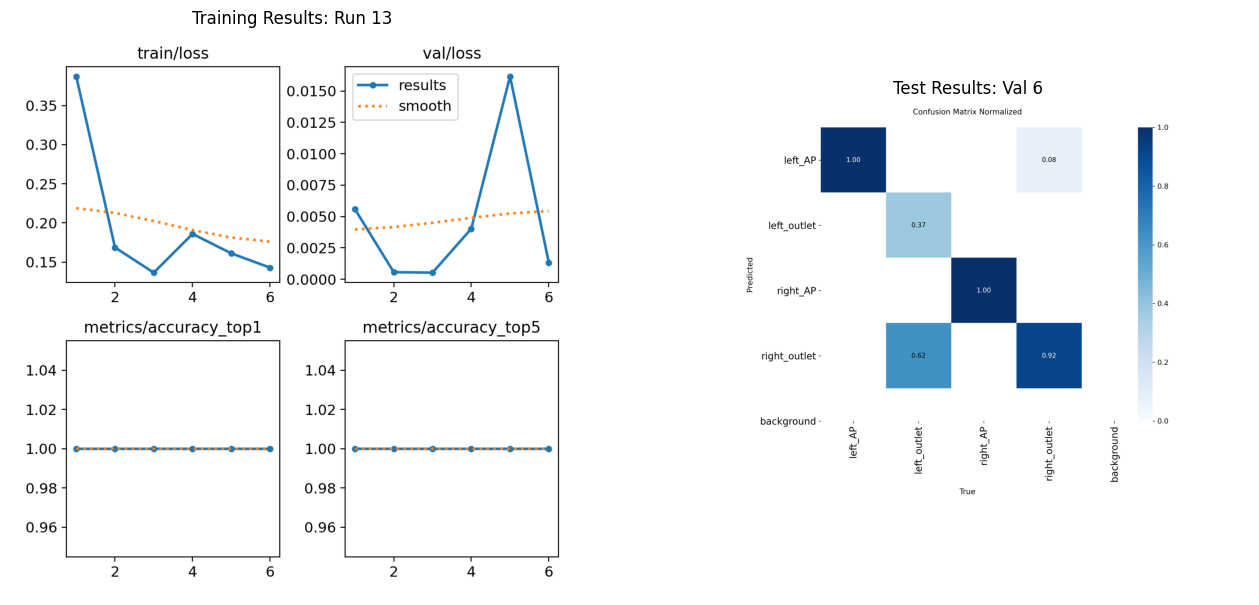

In [7]:
present_run(train_id=13, val_id=6)

### Augmentation by 35 degrees (Train 26, Val 15) ###

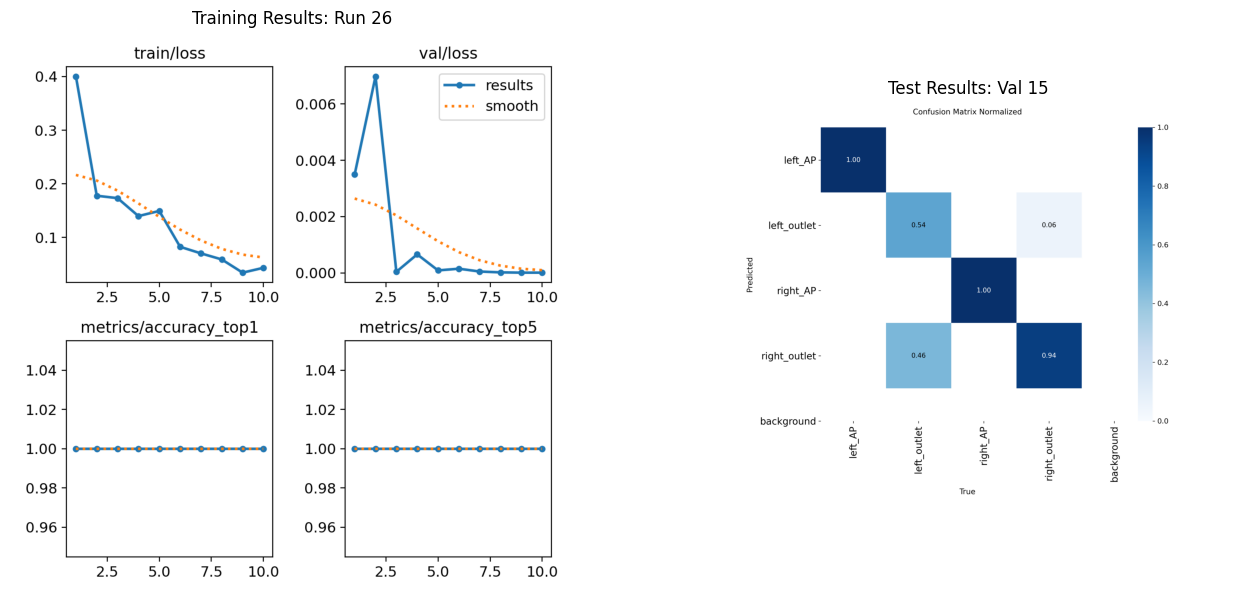

In [8]:
present_run(26,15)

### 35 degree rotation + 10% crop around edges + line in middle ###

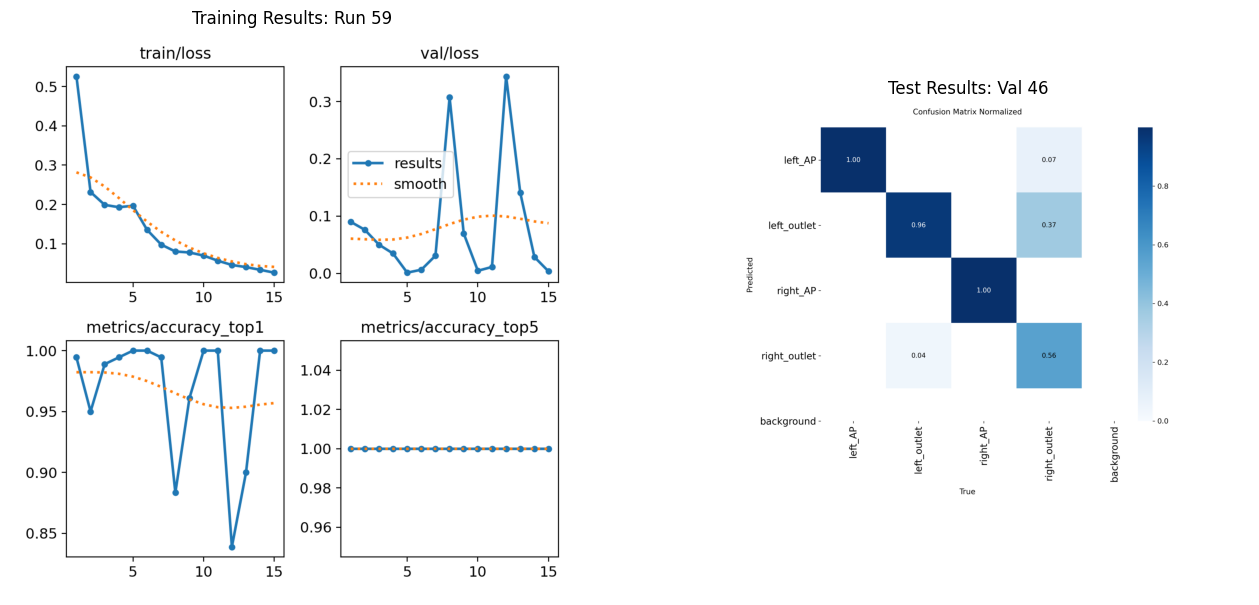

In [11]:
present_run(59, 46)

### 35 degree rotation + 10% crop around edges + line in middle + x4 training data ###

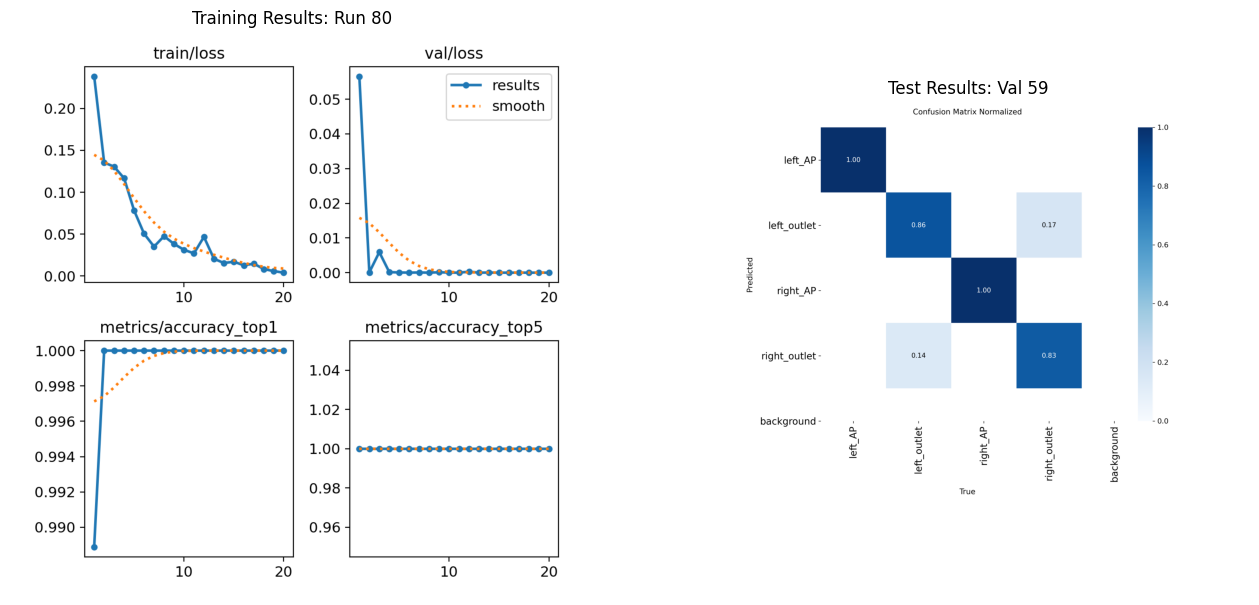

In [13]:
present_run(80, 59)

### 35 degree rotation + 10% crop around edges + line in middle + x4 training data, with AdamW optimizer ###

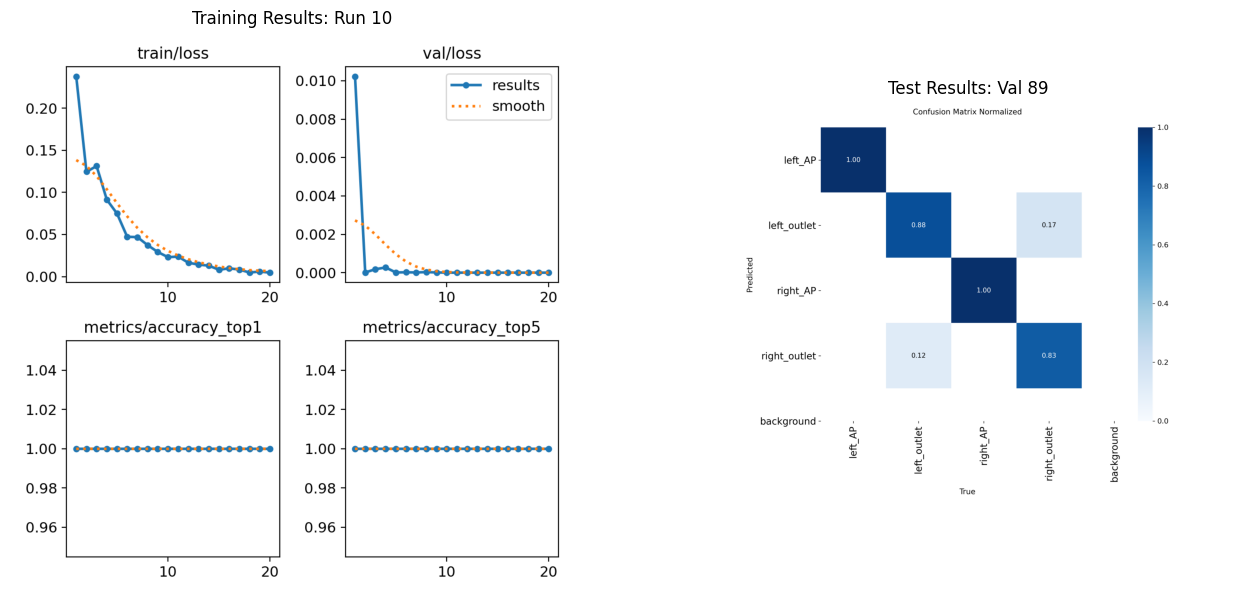

In [6]:
present_run(train_id=10, val_id=89)

### ### 35 degree rotation + 10% crop around edges + line in middle + x5 training data, with AdamW optimizer ###

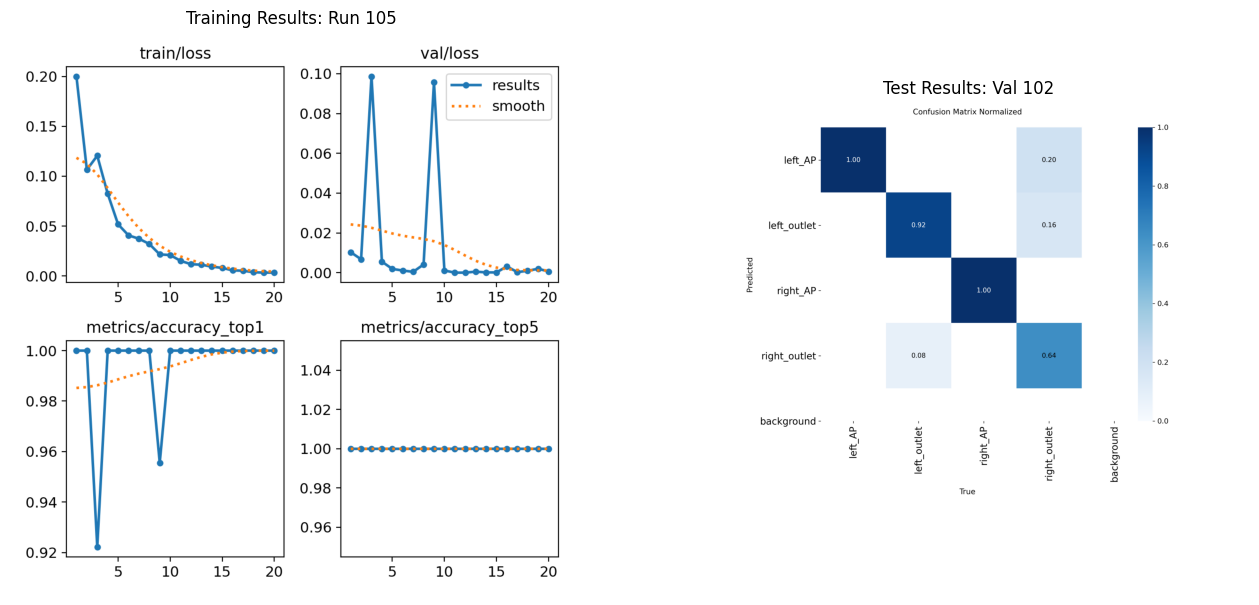

In [23]:
present_run(train_id=105, val_id=102)

### Bounding Box Crop + line + 35 degree rotation + x4 training data ###

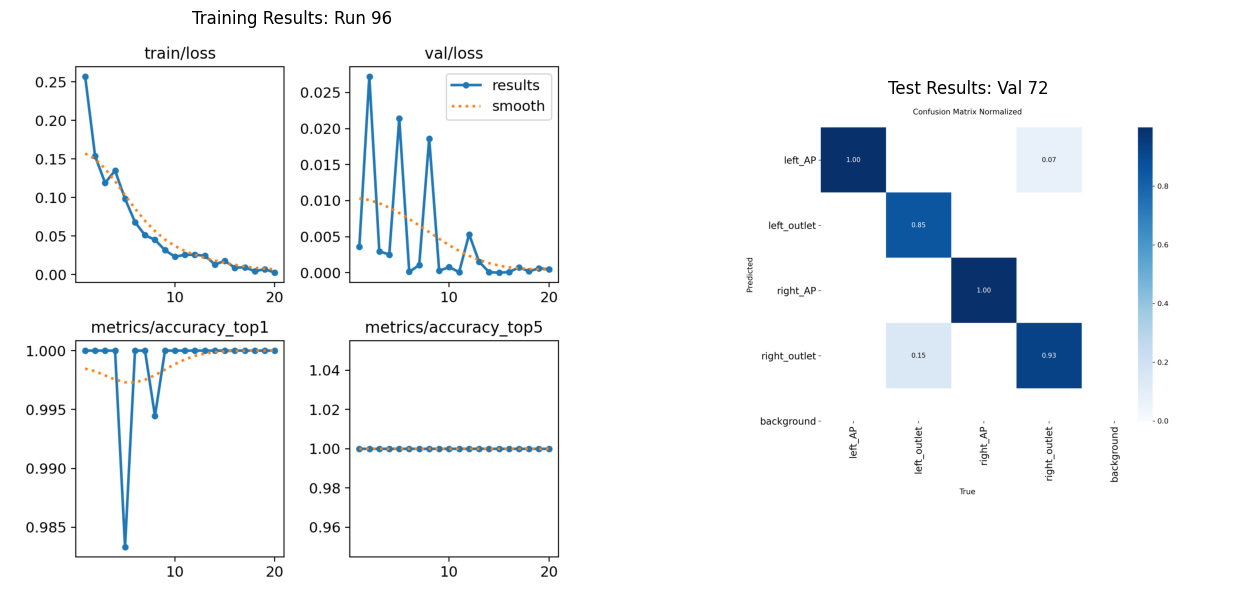

In [14]:
present_run(96, 72)

### Bounding Box Crop + line + 35 degree rotation + x5 training data + 25 epochs ###

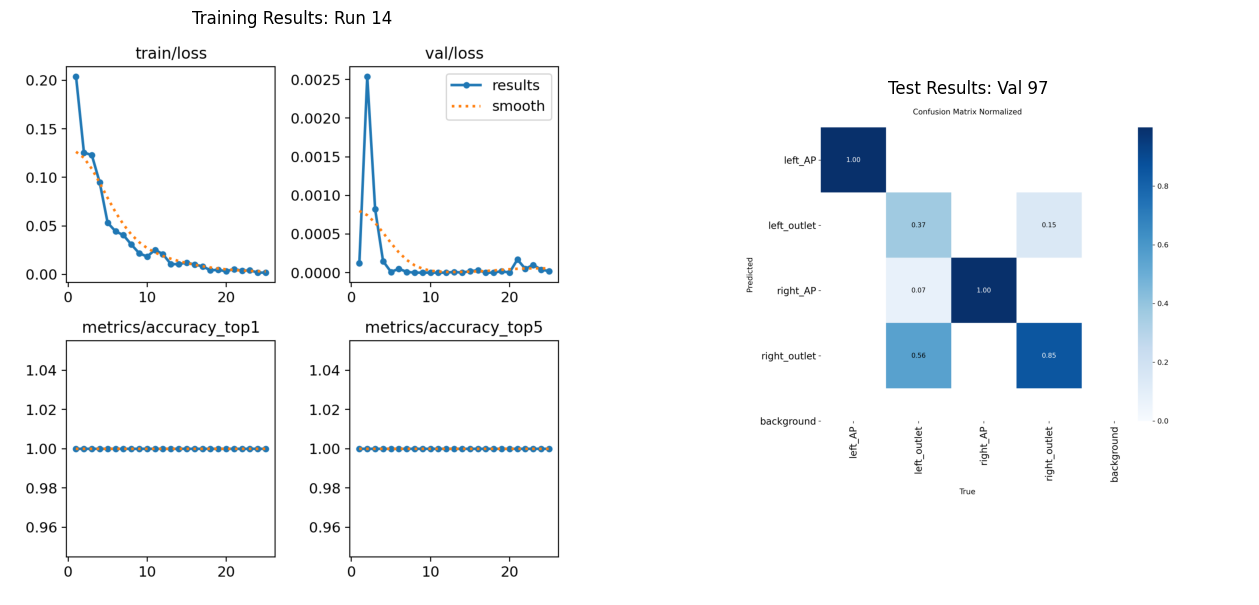

In [14]:
present_run(train_id=14, val_id=97)

### Image Segmentation Crop + line + 35 degree rotation + x4 training data ###

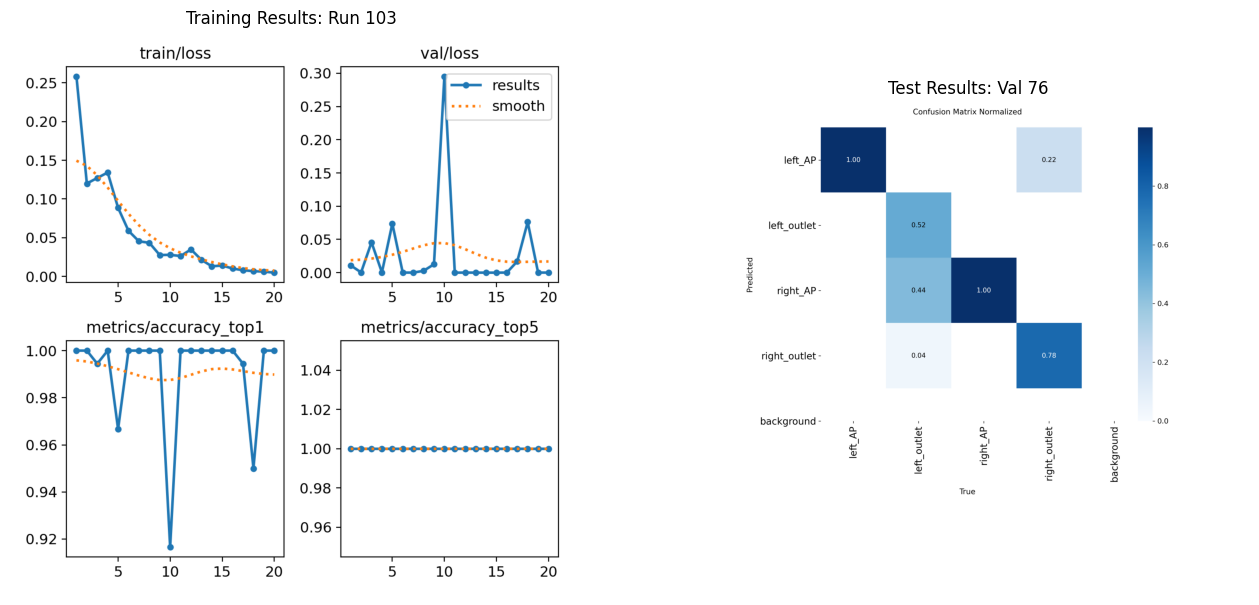

In [7]:
present_run(103, 76)

### Image Segmentation Crop + line + 35 degree rotation + x4 training data, increase epochs to 25, use dropout=0.1 ###

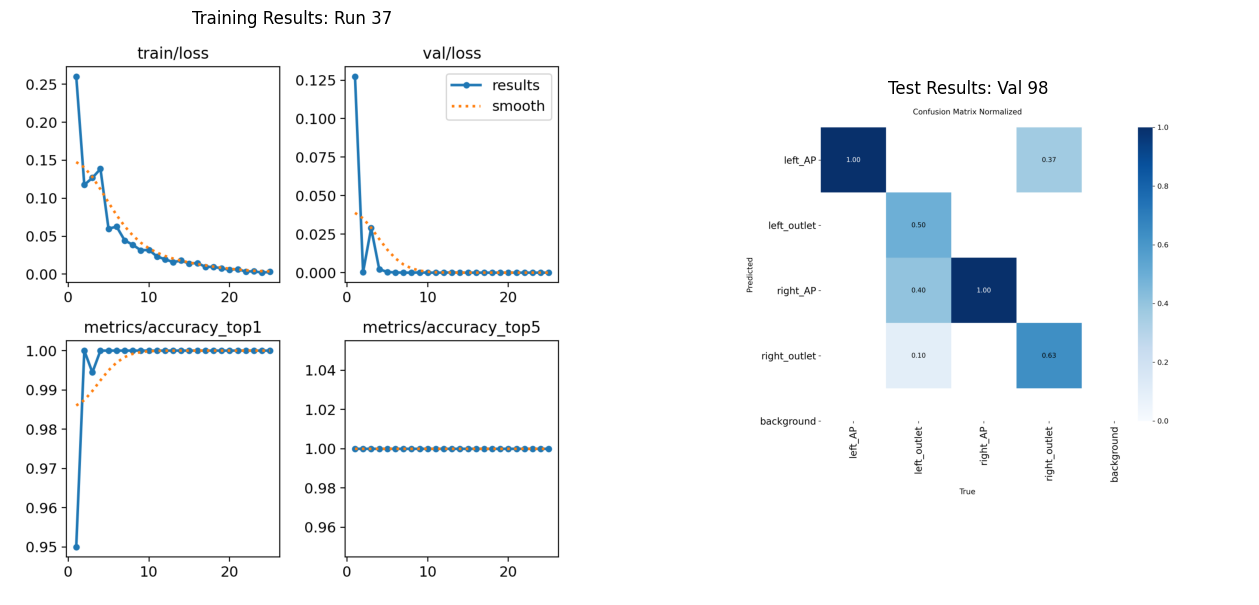

In [21]:
present_run(train_id=37, val_id=98)

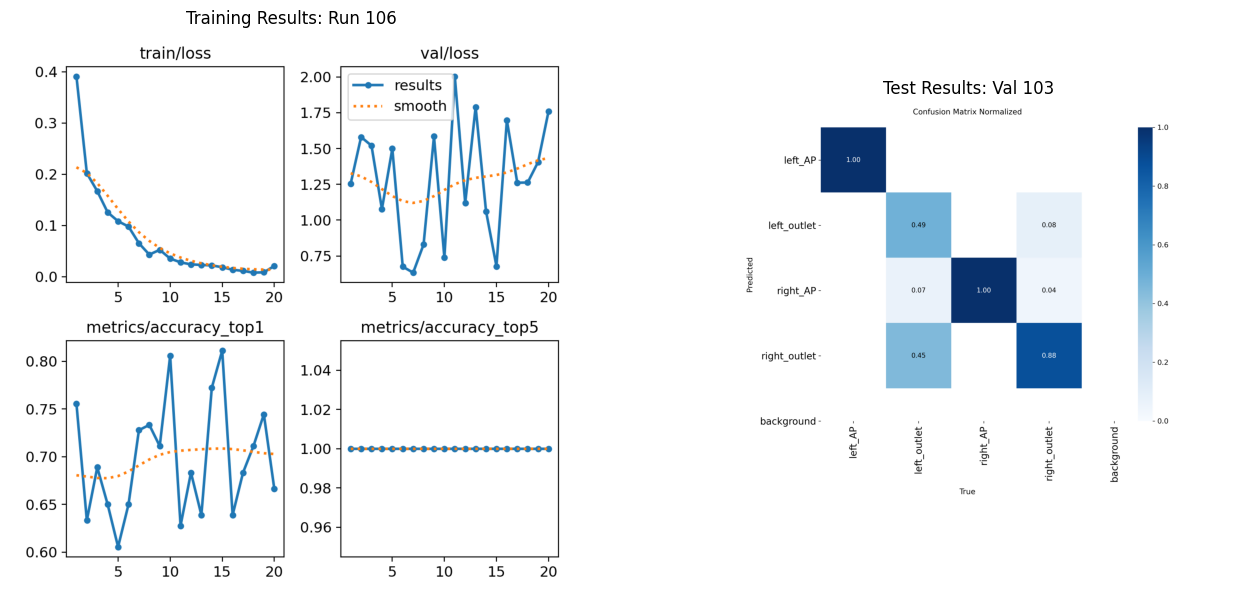

In [15]:
present_run(train_id=106, val_id=103)